# 전력 수요량 예측 모델링_3
##### 20191023 - 
##### 예측 해보기
Train 데이터로 모델을 학습, 검증 후 Test로 예측합니다.

 - ML 방법
    1. https://www.kaggle.com/fkstepz/step-by-step-house-prices-prediction
 - LSTM

In [2]:
# import package
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime, timedelta
%matplotlib inline

## 1. 데이터 불러오기

In [45]:
# 랜덤하게 뽑은 260세대에 선형보간법을 적용한 데이터
pre_train_1 = pd.read_csv("interpolation_1.csv")
#train['Time'] = pd.to_datetime(train['Time'])
#train = train.set_index('Time')

In [5]:
pre_train_1

,Time,X1472,X115,X1226,X273,X339,X774,X857,X1075,X1061,...,X933,X1238,X394,X829,X432,X1334,X1416,X803,X45,X1205
0,2016-07-26 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16904,2018-06-30 19:00:00,0.331,1.325,0.356,0.329,0.330,0.756,0.694,0.172,1.010,...,0.222,0.285,0.262,0.644,0.277,0.689,0.835,0.879,NaN,0.281
16905,2018-06-30 20:00:00,0.404,1.218,0.346,0.335,0.387,0.445,0.912,0.734,0.681,...,0.222,0.301,0.287,0.720,0.300,0.832,0.435,0.408,NaN,0.245
16906,2018-06-30 21:00:00,0.379,1.100,0.302,0.291,0.446,0.386,0.844,0.934,0.548,...,0.222,0.297,0.292,0.694,0.305,0.484,0.487,0.636,NaN,0.483
16907,2018-06-30 22:00:00,0.553,1.094,0.233,0.278,0.385,0.393,0.840,0.715,0.589,...,0.222,0.406,0.258,0.582,0.233,0.781,0.318,0.504,NaN,0.467


In [8]:
# 모든 행이 NaN인 세대 수 1301-1293=8세대
NaN_list = set(pre_train_1.dropna(how='all', axis=1).keys())
set(pre_train_1.keys()).difference(NaN_list)

NaN_X = set(pre_train_1.keys()).difference(NaN_list)

In [44]:
pre_train_1.keys()

Index(['X1472', 'X115', 'X1226', 'X273', 'X339', 'X774', 'X857', 'X1075',
       'X1061', 'X1091',
       ...
       'X933', 'X1238', 'X394', 'X829', 'X432', 'X1334', 'X1416', 'X803',
       'X45', 'X1205'],
      dtype='object', length=260)

In [9]:
# 결측치가 아닌 행의 위치 DF
first_notnull_2 = []  # 빈 list

for i in pre_train_1.keys()[1:]:
    if i not in NaN_X:
       _ = pre_train_1[i]
       first_notnull_2.append(_[_.isnull() == False].index[0])
    else:
        first_notnull_2.append(0)
        
df_notnull_2 = pd.DataFrame(first_notnull_2, list(pre_train_1.keys()[1:]))
df_notnull_2.columns = ['not_blank_num']

In [39]:
df_notnull_2

,not_blank_num
X1472,13645
X115,219
X1226,13645
X273,9600
X339,9575
...,...
X1334,13645
X1416,13645
X803,13645
X45,0


In [25]:
pd.Series(first_notnull_2).value_counts()

13645    212
9575      14
9600       9
15152      7
9623       3
9469       3
219        3
9624       2
0          2
9590       1
9574       1
13634      1
9485       1
9334       1
dtype: int64

In [37]:
df_notnull_2[df_notnull_2['not_blank_num'] != 13645].count()

not_blank_num    48
dtype: int64

In [10]:
# index Time으로 고정
pre_train_1 = pre_train_1.set_index('Time')

## ARIMA
1. https://towardsdatascience.com/time-series-in-python-part-2-dealing-with-seasonal-data-397a65b74051
2. https://byeongkijeong.github.io/ARIMA-with-Python/

In [26]:
start_num

13645

In [13]:
start_num = df_notnull_2.loc['X1226'][0]
pre_train_1[['X1226']][start_num:]

,X1226
Time,
2018-02-15 00:00:00,0.029
2018-02-15 01:00:00,0.079
2018-02-15 02:00:00,0.083
2018-02-15 03:00:00,0.085
2018-02-15 04:00:00,0.087
...,...
2018-06-30 19:00:00,0.356
2018-06-30 20:00:00,0.346
2018-06-30 21:00:00,0.302


In [46]:
X1226_df = pd.DataFrame(pre_train_1[['X1226']][start_num:])
X1226_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 13645 to 16908
Data columns (total 1 columns):
X1226    3264 non-null float64
dtypes: float64(1)
memory usage: 25.6 KB


In [52]:
# Train, Test 개수 구하기
print("Train 개수 :", round(X1226_df.shape[0]*0.7))
print("Test  개수 :", X1226_df.shape[0] - round(X1226_df.shape[0]*0.7))

Train 개수 : 2285
Test  개수 : 979


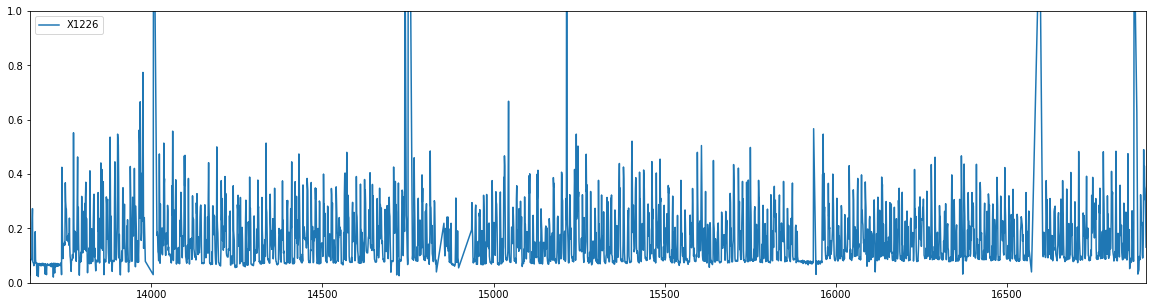

In [68]:
# split train test
X1226_train = df.iloc[:-979, :]
X1226_test = df.iloc[-979:, :]

# set index to timedata
X1226_train.index = pd.to_datetime(X1226_train.index)
X1226_test.index = pd.to_datetime(X1226_test.index)

# predict
X1226_pred = X1226_test.copy()

X1226_df.plot(figsize=(20,5))
plt.ylim(0,1)
plt.show()

## 시계열분석
https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

In [67]:
# package load
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [69]:
# Forecast quality metrics
# R2 : sklearn.metrics.r2_score
# MAE : sklearn.metrics.mean_absolute_error
# MedAE : sklearn.metrics.median_absolute_error
# MSE : sklearn.metrics.mean_squared_error
# MSLE : sklearn.metrics.mean_squared_log_error
# MAPE : def mean_absolute_percentage_error(y_true, y_pred): 
#    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## XGBoost
: tree-based모델로, train에서 발견된 값 중 최대값 이상의 값(최소값 이하의 값)을 추론,예측할 수 없음. 

이를 해결하기 위해서는 trend를 제거하거나, series를 stationary하도록 만들어야 함

* 이외에 고려할만한 ML모델 : SVM, RF, MLP

## LSTM(Long Short-Term Memory) with Keras

## LSTM 첫번째

https://roboreport.co.kr/%EB%94%A5%EB%9F%AC%EB%8B%9Dlstm%EC%9C%BC%EB%A1%9C-%EC%95%84%ED%8C%8C%ED%8A%B8-%EC%A7%80%EC%88%98-%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0-1-%ED%9B%88%EB%A0%A8-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EC%83%9D/

RNNs(Recurrent Neural networks)의 한종류  
시계열 데이터의 형태를 갖는 데이터에서 패턴을 인식하는 ANN

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### 1. load data

In [147]:
# 보간법으로 채운 test data
test = pd.read_csv("보간법/test_interpolation.csv")
test['Time'] = pd.to_datetime(test['Time'])
test = test.set_index('Time')

In [236]:
# test 결측치 갯수
test.isnull().sum()

X303    1320
X241    1320
X435    1426
X402    1426
X352    1426
        ... 
X443    1426
X347    1426
X75        0
X107       0
X230    1451
Length: 199, dtype: int64

In [149]:
test.head()

,X303,X241,X435,X402,X352,X305,X350,X326,X299,X160,...,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
Time,,,,,,,,,,,,,,,,,,,,,
2017-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
2017-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2017-07-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
2017-07-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
2017-07-01 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202,0.021,NaN


In [150]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-07-01 00:00:00 to 2018-06-30 23:00:00
Columns: 199 entries, X303 to X230
dtypes: float64(199)
memory usage: 13.4 MB


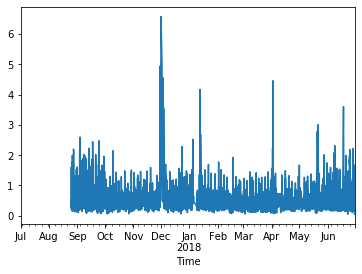

In [151]:
test['X303'].plot()

In [152]:
# X303 한 세대에 대해서 dropna(axis=0)
test_X303 = pd.DataFrame(test['X303'].dropna(axis=0))
test_X303.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7440 entries, 2017-08-25 00:00:00 to 2018-06-30 23:00:00
Data columns (total 1 columns):
X303    7440 non-null float64
dtypes: float64(1)
memory usage: 116.2 KB


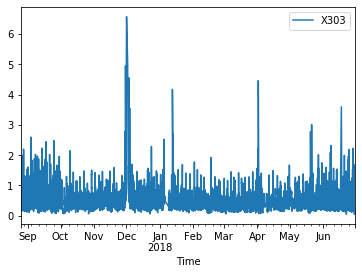

In [153]:
test_X303.plot()

### 2. Data split

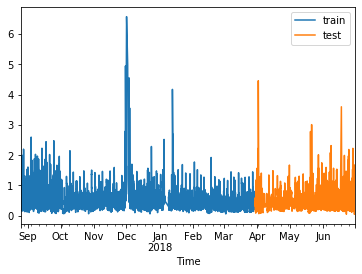

In [154]:
# test_X303을 train, test로 데이터 분리 
# 2017-08-25 00:00:00 to 2018-06-30 23:00:00()
split_n = round(len(test_X303)*0.7)  # 5208번째까지 train

train_1 = test_X303.iloc[:split_n]
test_1 = test_X303.iloc[split_n:]

ax = train_1.plot()
test_1.plot(ax=ax)
plt.legend(['train', 'test'])

### 3. Data fit_transform, scailing

In [162]:
# 분포 추정, 변환, 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

train_sc = scaler.fit_transform(train_1)  # fit + transform
test_sc = scaler.transform(test_1)  # scailing

print("train_sc :\n", train_sc)
print("test_sc :\n", test_sc)

train_sc :
 [[0.07218553]
 [0.05314084]
 [0.05529105]
 ...
 [0.11442175]
 [0.08186147]
 [0.05882353]]
test_sc :
 [[0.07418215]
 [0.08124712]
 [0.06465981]
 ...
 [0.12624789]
 [0.07341422]
 [0.06450622]]


In [214]:
# 사용하기 편리하도록 df로 변환
train_sc_df = pd.DataFrame(train_sc, columns=['X303'], index=train_1.index)
test_sc_df = pd.DataFrame(test_sc, columns=['X303'], index=test_1.index)
train_sc_df.head()

,X303
Time,
2017-08-25 00:00:00,0.072186
2017-08-25 01:00:00,0.053141
2017-08-25 02:00:00,0.055291
2017-08-25 03:00:00,0.052680
2017-08-25 04:00:00,0.038397


In [215]:
test_sc_df

,X303
Time,
2018-03-30 00:00:00,0.074182
2018-03-30 01:00:00,0.081247
2018-03-30 02:00:00,0.064660
2018-03-30 03:00:00,0.056059
2018-03-30 04:00:00,0.041775
...,...
2018-06-30 19:00:00,0.017509
2018-06-30 20:00:00,0.250499
2018-06-30 21:00:00,0.126248


In [216]:
# sliding window 구성하기
for s in range(1, 13):  # 과거 시간 단위 24개가 훈련속성 
    train_sc_df['shift_{}'.format(s)] = train_sc_df['X303'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['X303'].shift(s)

train_sc_df.head()

,X303,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Time,,,,,,,,,,,,,
2017-08-25 00:00:00,0.072186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-25 01:00:00,0.053141,0.072186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-25 02:00:00,0.055291,0.053141,0.072186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-25 03:00:00,0.052680,0.055291,0.053141,0.072186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-25 04:00:00,0.038397,0.052680,0.055291,0.053141,0.072186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4. Make train test set 

In [217]:
train_sc_df.shape

(5208, 13)

In [220]:
X_train = train_sc_df.dropna().drop('X303', axis=1)
y_train = train_sc_df.dropna()[['X303']]

X_test = test_sc_df.dropna().drop('X303', axis=1)
y_test = test_sc_df.dropna()[['X303']]

X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Time,,,,,,,,,,,,
2017-08-25 12:00:00,0.047765,0.047458,0.114575,0.237598,0.040854,0.036861,0.035478,0.038397,0.052680,0.055291,0.053141,0.072186
2017-08-25 13:00:00,0.030564,0.047765,0.047458,0.114575,0.237598,0.040854,0.036861,0.035478,0.038397,0.052680,0.055291,0.053141
2017-08-25 14:00:00,0.025342,0.030564,0.047765,0.047458,0.114575,0.237598,0.040854,0.036861,0.035478,0.038397,0.052680,0.055291
2017-08-25 15:00:00,0.029028,0.025342,0.030564,0.047765,0.047458,0.114575,0.237598,0.040854,0.036861,0.035478,0.038397,0.052680
2017-08-25 16:00:00,0.037936,0.029028,0.025342,0.030564,0.047765,0.047458,0.114575,0.237598,0.040854,0.036861,0.035478,0.038397


In [222]:
y_train.head()

,X303
Time,
2017-08-25 12:00:00,0.030564
2017-08-25 13:00:00,0.025342
2017-08-25 14:00:00,0.029028
2017-08-25 15:00:00,0.037936
2017-08-25 16:00:00,0.023499


In [223]:
# df -> ndarray로 변환 

print("X_train type :", type(X_train))
print("y_train type :", type(y_train))
print("X_test type :", type(X_test))
print("y_test type :", type(y_test)) # 전부 df

# ndarray로 변환 
X_train = X_train.values
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

X_train type : <class 'pandas.core.frame.DataFrame'>
y_train type : <class 'pandas.core.frame.DataFrame'>
X_test type : <class 'pandas.core.frame.DataFrame'>
y_test type : <class 'pandas.core.frame.DataFrame'>
(5196, 12)
(5196, 1)


In [224]:
# 2976개의 데이터와 2232의 slot을가지고 있으므로
# 2232, 1로 reshape
X_train_t = X_train.reshape(X_train.shape[0], 12, 1)
X_test_t = X_test.reshape(X_test.shape[0], 12, 1)

print("최종 DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train)

최종 DATA
(5196, 12, 1)
[[[0.04776532]
  [0.04745815]
  [0.11457533]
  ...
  [0.05529105]
  [0.05314084]
  [0.07218553]]

 [[0.03056366]
  [0.04776532]
  [0.04745815]
  ...
  [0.05268008]
  [0.05529105]
  [0.05314084]]

 [[0.02534173]
  [0.03056366]
  [0.04776532]
  ...
  [0.03839656]
  [0.05268008]
  [0.05529105]]

 ...

 [[0.09230533]
  [0.10797113]
  [0.04653663]
  ...
  [0.04377208]
  [0.03670711]
  [0.03962525]]

 [[0.11442175]
  [0.09230533]
  [0.10797113]
  ...
  [0.02948856]
  [0.04377208]
  [0.03670711]]

 [[0.08186147]
  [0.11442175]
  [0.09230533]
  ...
  [0.02273076]
  [0.02948856]
  [0.04377208]]]
[[0.03056366]
 [0.02534173]
 [0.0290278 ]
 ...
 [0.11442175]
 [0.08186147]
 [0.05882353]]


In [225]:
# LSTM 모델 생성
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping

K.clear_session()
    
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 

# loss 함수:  MAPE
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [226]:
# model train
# 오후 5:58 ~
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_t, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

Epoch 1/100
5196/5196 [==============================] - 2s 432us/step - loss: 1844.7066
Epoch 2/100
5196/5196 [==============================] - 2s 316us/step - loss: 11306.8551
Epoch 00002: early stopping


In [231]:
score = model.evaluate(X_test_t, y_test, batch_size=30)
print(score)  # score값: 87.411 

2220/2220 [==============================] - 0s 145us/step
87.41128076089394


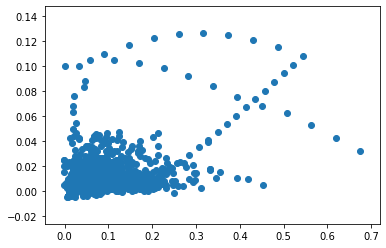

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt


y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)

In [229]:
y_pred

array([[0.0063405 ],
       [0.00520592],
       [0.00383986],
       ...,
       [0.00182477],
       [0.00398506],
       [0.00541594]], dtype=float32)

In [ ]:
## 전체 test데이터로 넣어보기 

## LSTM 2번째 
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/



In [126]:
# import package
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [119]:
# def function
# 1. convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [123]:
#### data = test_X303
# 1. normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(test_X303)

In [121]:
# 2. split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5208 2232


In [127]:
# 3-1. reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [141]:
trainY

array([0.08355051])

In [128]:
# 3-2. reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [133]:
# 4. create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [138]:
trainX.shape
trainY.shape

(1,)

In [136]:
#early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(trainX, trainY, epochs=50, batch_size=30, verbose=1)

ValueError: Input arrays should have the same number of samples as target arrays. Found 5206 input samples and 1 target samples.